Step 2. 얼굴 검출 & 랜드마크 검출 하기
오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.

Step 3. 스티커 적용 위치 확인하기
고양이 수염이 적용 될 볼 위치를 landmark를 사용해서 계산해 주세요.   
---


아래 프로그램은 이미지 처리 관련 패키지들   
빼먹지 말고 다운로드 하자.   


참고) 마지막 부분 보면 kernel restart해야지 사용할 수 있다고 뜨는 부분 참고.    
껐다가 재접속 할 것!! 

In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install cmake

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install dlib

Note: you may need to restart the kernel to use updated packages.


In [137]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
print("🌫🛸")


🌫🛸


내 이미지 사진은 3:4 이미지로 480 x 640으로 맞춰줌 

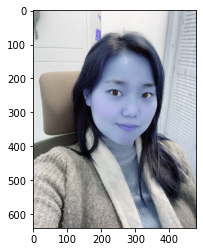

In [138]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image2.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

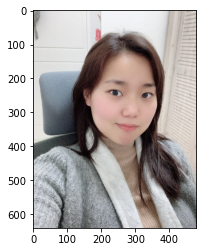

In [139]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

dlib의 hog detector 로 얼굴 찾기 

In [140]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("🌫🛸")

🌫🛸


Detector 이용해서 boudning box 만들기    
dlib은 BGR 로 받기 때문에 RGB로 변환해주는 cvtColor로 RGB로 변환 

In [141]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("🌫🛸")

🌫🛸


### Step 2. 얼굴 검출 & Landmark 표시하기


rectangles[[(167, 167) (390, 390)]]


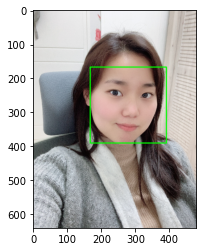

In [142]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

Dlib의 제공되는 모델 사용 다운로드 & Unzipped 후,   
저장된 landmark 불러오기 

In [143]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [144]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


#### 랜드마크 영상에 출력하기 

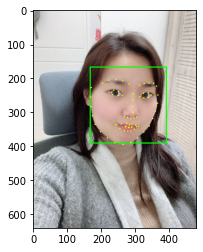

In [145]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 좌표 확인하기 

1. 코 중심점 찾기   
2. (x,y)   
3. (w,h)   

In [146]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[0][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(292, 300)
(x,y) : (292,115)
(w,h) : (224,224)


### Step3. 스티커 적용하기 & Resize 하기   
볼은 '턱', '눈', '입', '코' 사이에 있다는 점을 이용해 주세요. 비율로 계산하는 방법 잊지 않으셨죠?

[hint] 2, 36, 48, 30 번 인덱스를 이용

In [147]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(224, 224, 3)


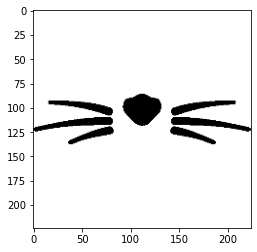

In [148]:
plt.imshow(img_sticker) #스티커 사진 확인 

원본 이미지에 스티커 이미지 추가하기 위해, x,y 좌표 조정.   
이미지 시작점은 top-left 좌표 이기 때문

(중요!) 아래식 보면 조금 다른데, 내 원본 이미지 크기가 다르다 보니까 코에 맞추기가 너무 어려워서  임의 값 넣고 막 돌려보면서 넣어서 코에 맞춤! 

In [149]:
refined_x = x - w // 2 # left
refined_y = y + w//3 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (180,189)


음수에 대한 예외 처리 필요 (저기 음수는 사진 밖을 벗어나게 되는 스티커 이미지를 표시함.

Top의 y좌표는 원본 이미지의 경계 값으로 수정 

#### 원본 이미지에 스티커 적용하기   

[참고!] 여기서 스티커의 흰색 부분이 많이들 같이 따라오는데 (누끼를 따놔도 같이 오는 경우가 조금씩 있음)   
이럴 경우 안에 np.where(img_sticker==0 부분에서 0을 255로 변환 해주어야한다.   
그렇게 되면 255=흰색 부분은 버리고 나머지를 사용하겠다가 적용 된다.

여기서 img_show[] 부분에서 refined가 [중요!] 음수가 아닐 때에는 refined_y:refined_y+img_sticker.shape[0]을 해주셔야 합니다.

In [150]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

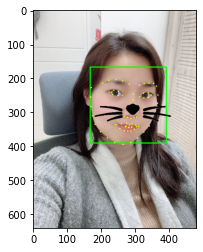

In [151]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### 원본 이미지 범위 벗어난 스티커 부분 제거 ( if 로 사용)
스티커가 이미지 값에서 밖으로 나가게 될때 0으로 만들어서 안보이게 하기 

In [152]:
if refined_y < 0 :
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0
            
print (img_sticker.shape)

(224, 224, 3)


In [153]:
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (180,189)


In [170]:
import numpy as np
import cv2
img= cv2.addWeighted

cv2.Addweighted 사용해서 스티커 이미지 투명도 조절하기.

#### Bouding Box & Landmark 제거하고 출력하기! 

윗부분에서 np.where (img_sticker==255로 하였을때는 흰색 없이 잘 나왔는데, 이번에는 또 흰색이랑 같이 나왔다..

In [171]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

ValueError: operands could not be broadcast together with shapes (224,224,3) (35,224,3) (224,224,3) 

여기서!! plt.imshow는 위에 sticker_area와 별도로 실행 해주어야함! 
안그럴 경우, 하얀색을 그대로 가지고 오는 경향이 있음

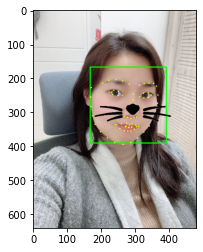

In [172]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### Step 5. 문제점 찾아보기 

##### (1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

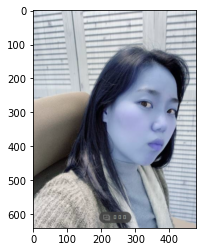

In [173]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image3.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

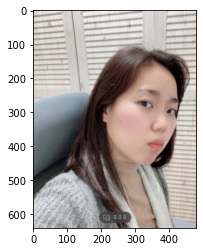

In [174]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

rectangles[[(167, 167) (390, 390)]]


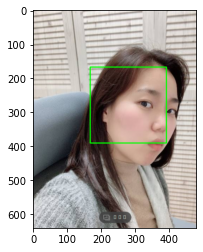

In [175]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

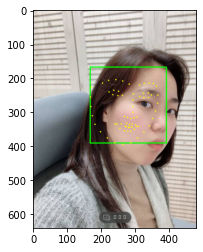

In [176]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [177]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(224, 224, 3)


In [178]:
refined_x = x - w // 2 # left
refined_y = y + w//3 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (180,189)


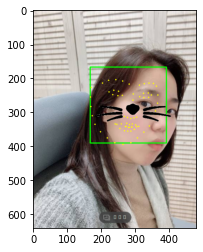

In [181]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

바운딩과 랜드마크 부터 잘 인식을 하지 못한다.. 

In [185]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

ValueError: operands could not be broadcast together with shapes (224,224,3) (35,224,3) (224,224,3) 

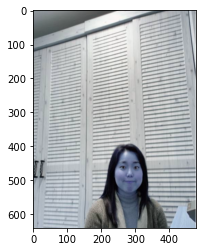

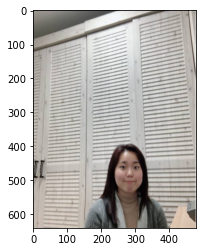

In [186]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image4.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

rectangles[[(167, 167) (390, 390)]]


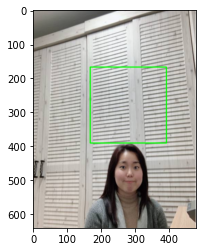

In [187]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

헐...? 뭐지? 왜 안되지..?   
일단 각도와 거리 변경 하였을 경우, 둘다 틀리게 반응함.   
---




* 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?    

당연히 각도에 맞게 변해야한다고 생각한다. 각도에 따라서 원본 이미지에서 벗어나면 없어지는게 아니라, 랜드마크가 보이지 않으면 사라지는 걸로 설정하는게 좋을 거 같다.    


* 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?   

확실하진 않지만, 어느 정도 얼굴이 가까이 왔을때만 인식을 하게 함수가 짜여있고, 직면으로 보았을때만 랜드마크 또한 인식하게 만들어져 있어서 그런 것 같다.
   
   
좌/우로 보고있거나, 멀리 있을때에 대한 학습? 및 이에 알맞은 함수를 사용하게 되면, 제대로 인식하지 않을까? 


* 실행 속도가 중요할까요?   

요즘엔 Snow 같이 스티커 앱으로는 정말 빠르게 잘 되는 앱들이 많기 때문에
이와 경쟁하기 위해선 속도가 가장 중요하다고 생각한다.   


* 스티커앱을 만들 때 정확도가 얼마나 중요할까요?   

완전 중요하다고 생각한다. 사실 요즘에 나오는 스티커 앱들은 얼굴에 안맞는게 없을 정도니.. 사실상 얼굴에 맞지 않으면 아무리 다른 대단한 기술이 있더라도 무용지물이 될 것 이라고 생각한다.  Facial Recognition인데 Face를 인식을 못한다는 것 자체가, 신뢰성을 잃어버리기 때문이다.     

P.S, 혹시나 채점중.. 저와 같은 문제를 가지고 Bouding을 제거 못하고 계신분들이 있으면 알려주세요.. 함께 모여서 머리를 쥐어짜보는 것도 괜찮을 것 같네요 ㅎ.ㅎ 